# 18장 시퀀스 배열로 다루는 순환 신경망(RNN)

## 1. LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터를 확인해 보겠습니다.
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [8]:
# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다. epoch 원래 설정은 200이었으나, 실습을 위해 10회만 수행 합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.3895 - loss: 2.4829 - val_accuracy: 0.5410 - val_loss: 1.8565
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.5367 - loss: 1.7943 - val_accuracy: 0.5677 - val_loss: 1.6785
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 43s 85ms/step - accuracy: 0.5750 - loss: 1.6387 - val_accuracy: 0.5926 - val_loss: 1.5550
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.6229 - loss: 1.4428 - val_accuracy: 0.6300 - val_loss: 1.4531
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 87ms/step - accuracy: 0.6786 - loss: 1.2996 - val_accuracy: 0.6514 - val_loss: 1.3607
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.6991 - loss: 1.1833 - val_accuracy: 0.6638 - val_loss: 1.2927
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.7179 - loss: 1.0971 - val_accuracy: 0.6701 - val_loss: 1.2741
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.7473 - loss: 0.9989 - 

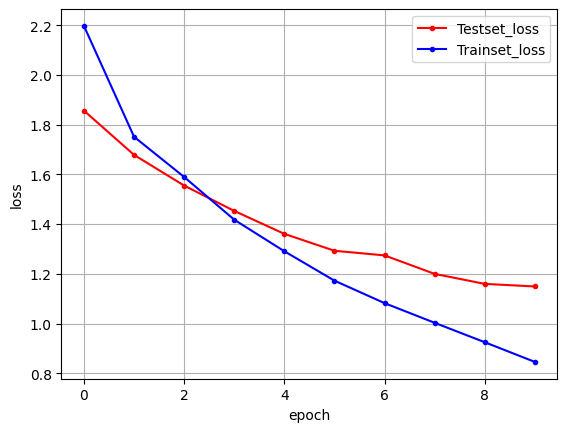

In [9]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다. 원래 epoch 100 이었으나, 실습을 위해 3회만 수행함.
history = model.fit(X_train, y_train, batch_size=40, epochs=3, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

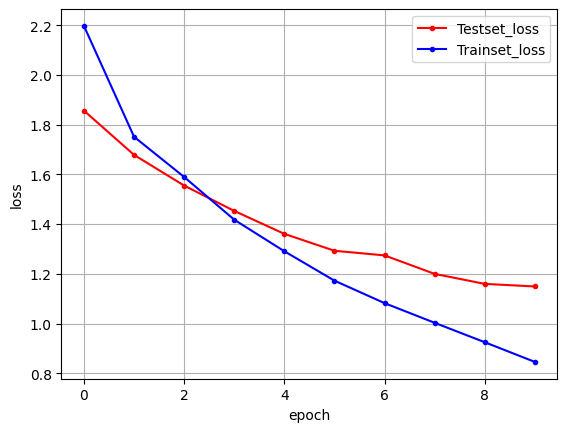

In [13]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 3. 어텐션을 사용한 신경망

In [14]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=ad4e9757e3e56a50fac1be6946a76d389c311e63e452410b16b6902a3fabd366
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras_self_attention import SeqSelfAttention

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100,  validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

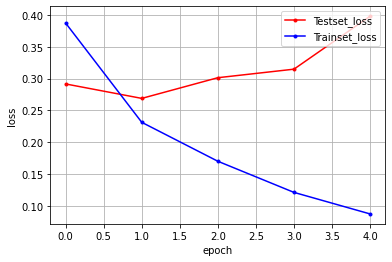

In [ ]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()